# Project Showcase Challenge: Generative Dog Images

## import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm_notebook as tqdm
from time import time
from PIL import Image
import matplotlib.image as mpimg
import xml.etree.ElementTree as ET
import random
from scipy.stats import truncnorm
import zipfile

import torch
import torch as th
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.nn.utils import spectral_norm

In [2]:
start = time()

## Define configurable hyperparameters

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# dataloader parameters
batch_size = 32
num_workers = 4
annotation_dir = '../input/generative-dog-images/annotation/Annotation/'
dog_dataset = '../input/generative-dog-images/all-dogs/all-dogs/'

# define optimizer hyperparameters
lr_g = 0.0004
lr_d = 0.0008
beta1 = 0.5
beta2 = 0.999

# define networks hyperparameters
nz = 64 # latent size vector
nfeats_g = 32
nfeats_d = 48
n_channels = 3

# define learning rate scheduler hyperparameters
min_lr = 0.00005
denom_epoch = 100

# training hyperparameters
epochs = 400
n_one = 1
real_label = 0.7
fake_label = 0.0
fixed_noise = torch.randn(batch_size, nz, n_one, n_one, device=device)

# evaluation metrics
ComputeLB = True

In [4]:
# In order to reproduce the results of this notebook, we need to execute this function to have proper seeding on each
# technical environment

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [5]:
def truncated_normal(size, threshold=1):
    values = truncnorm.rvs(-threshold, threshold, size=size)
    return values

## Dataset and DataLoader

In [6]:
class DataGenerator(Dataset):
    def __init__(self, directory, transform=None, n_samples=np.inf):
        self.directory = directory
        self.transform = transform
        self.n_samples = n_samples

        self.samples = self._load_subfolders_images(directory)
        if len(self.samples) == 0:
            raise RuntimeError("Found 0 files in subfolders of: {}".format(directory))

    def _load_subfolders_images(self, root):
        IMG_EXTENSIONS = (
        '.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

        def is_valid_file(x):
            return torchvision.datasets.folder.has_file_allowed_extension(x, IMG_EXTENSIONS)

        required_transforms = torchvision.transforms.Compose([
                torchvision.transforms.Resize(64),
                torchvision.transforms.CenterCrop(64),
        ])

        imgs = []
        paths = []
        for root, _, fnames in sorted(os.walk(root)):
            for fname in sorted(fnames)[:min(self.n_samples, 999999999999999)]:
                path = os.path.join(root, fname)
                paths.append(path)

        for path in paths:
            if is_valid_file(path):
                # Load image
                img = dset.folder.default_loader(path)

                # Get bounding boxes
                annotation_basename = os.path.splitext(os.path.basename(path))[0]
                annotation_dirname = next(
                        dirname for dirname in os.listdir(annotation_dir) if
                        dirname.startswith(annotation_basename.split('_')[0]))
                annotation_filename = os.path.join(annotation_dir,
                                                   annotation_dirname, annotation_basename)
                tree = ET.parse(annotation_filename)
                root = tree.getroot()
                objects = root.findall('object')
                for o in objects:
                    bndbox = o.find('bndbox')
                    xmin = int(bndbox.find('xmin').text)
                    ymin = int(bndbox.find('ymin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymax = int(bndbox.find('ymax').text)
                    
                    w = np.min((xmax - xmin, ymax - ymin))
                    bbox = (xmin, ymin, xmin+w, ymin+w)
                    object_img = required_transforms(img.crop(bbox))
                    imgs.append(object_img)
        return imgs

    def __getitem__(self, index):
        sample = self.samples[index]
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        return np.asarray(sample)
    
    def __len__(self):
        return len(self.samples)


In [7]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.3),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = DataGenerator(dog_dataset, transform=transform,n_samples=25000)


train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,batch_size=batch_size, num_workers=num_workers)

## For Visualization

In [8]:
def show_generated_img_all():
    gen_z = torch.randn(batch_size, nz, n_one, n_one, device=device)
    gen_images = netG(gen_z).to("cpu").clone().detach()
    gen_images = gen_images.numpy().transpose(0, 2, 3, 1)
    gen_images = (gen_images+1.0)/2.0
    fig = plt.figure(figsize=(25, 16))
    for ii, img in enumerate(gen_images):
        ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
        plt.imshow(img)  

In [9]:
### This is to show one sample image for iteration of chosing
def show_generated_img():
    noise = torch.randn(n_one, nz, n_one, n_one, device=device)
    gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
    gen_image = gen_image.numpy().transpose(1, 2, 0)
    gen_image = ((gen_image+1.0)/2.0)
    plt.imshow(gen_image)
    plt.show()

## Pixel Wise Normalization

In [10]:
# ----------------------------------------------------------------------------
# Pixelwise feature vector normalization.
# reference: https://github.com/tkarras/progressive_growing_of_gans/blob/master/networks.py#L120
# ----------------------------------------------------------------------------
class PixelwiseNorm(nn.Module):
    def __init__(self):
        super(PixelwiseNorm, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the module
        :param x: input activations volume
        :param alpha: small number for numerical stability
        :return: y => pixel normalized activations
        """
        y = x.pow(2.).mean(dim=1, keepdim=True).add(alpha).sqrt()  # [N1HW]
        y = x / y  # normalize the input x volume
        return y

## Mini-Batch Standard Deviation

In [11]:
class MinibatchStdDev(nn.Module):
    """
    Minibatch standard deviation layer for the discriminator
    """

    def __init__(self):
        """
        derived class constructor
        """
        super(MinibatchStdDev, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the layer
        :param x: input activation volume
        :param alpha: small number for numerical stability
        :return: y => x appended with standard deviation constant map
        """
        batch_size, _, height, width = x.shape
        # [B x C x H x W] Subtract mean over batch.
        y = x - x.mean(dim=0, keepdim=True)
        # [1 x C x H x W]  Calc standard deviation over batch
        y = th.sqrt(y.pow(2.).mean(dim=0, keepdim=False) + alpha)

        # [1]  Take average over feature_maps and pixels.
        y = y.mean().view(1, 1, 1, 1)

        # [B x 1 x H x W]  Replicate over group and pixels.
        y = y.repeat(batch_size,1, height, width)

        # [B x C x H x W]  Append as new feature_map.
        y = th.cat([x, y], 1)
        # return the computed values:
        return y

# Define the Model

## Generator

In [12]:
class Generator(nn.Module):
    def __init__(self, nz, nfeats, nchannels):
        super(Generator, self).__init__()

        # input is Z, going into a convolution
        self.conv1 = spectral_norm(nn.ConvTranspose2d(nz, nfeats * 8, 4, 1, 0, bias=False))
        self.conv2 = spectral_norm(nn.ConvTranspose2d(nfeats * 8, nfeats * 8, 4, 2, 1, bias=False))
        self.conv3 = spectral_norm(nn.ConvTranspose2d(nfeats * 8, nfeats * 4, 4, 2, 1, bias=False))
        self.conv4 = spectral_norm(nn.ConvTranspose2d(nfeats * 4, nfeats * 2, 4, 2, 1, bias=False))
        self.conv5 = spectral_norm(nn.ConvTranspose2d(nfeats * 2, nfeats, 4, 2, 1, bias=False))
        self.conv6 = spectral_norm(nn.ConvTranspose2d(nfeats, nchannels, 3, 1, 1, bias=False))
        self.pixnorm = PixelwiseNorm()
    def forward(self, x):

        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv3(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv4(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv5(x))
        x = self.pixnorm(x)
        x = torch.tanh(self.conv6(x))
        
        return x


## Discriminator

In [13]:
class Discriminator(nn.Module):
    def __init__(self, nchannels, nfeats):
        super(Discriminator, self).__init__()

        # input is (nchannels) x 64 x 64
        self.conv1 = nn.Conv2d(nchannels, nfeats, 4, 2, 1, bias=False)
        # state size. (nfeats) x 32 x 32
        self.conv2 = spectral_norm(nn.Conv2d(nfeats, nfeats * 2, 4, 2, 1, bias=False))
        self.bn2 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats*2) x 16 x 16
        self.conv3 = spectral_norm(nn.Conv2d(nfeats * 2, nfeats * 4, 4, 2, 1, bias=False))
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*4) x 8 x 8
        self.conv4 = spectral_norm(nn.Conv2d(nfeats * 4, nfeats * 8, 4, 2, 1, bias=False))
        self.bn4 = nn.MaxPool2d(2)
        # state size. (nfeats*8) x 4 x 4
        self.batch_discriminator = MinibatchStdDev()
        self.conv5 = spectral_norm(nn.Conv2d(nfeats * 8 +1, 1, 2, 1, 0, bias=False))
        # state size. 1 x 1 x 1
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        x = self.batch_discriminator(x)
        x = torch.sigmoid(self.conv5(x))
        return x.view(-1, 1)

## Build Complete Network 

In [14]:
# define Generator and Discriminator
netG = Generator(nz, nfeats_g, n_channels).to(device)
netD = Discriminator(n_channels, nfeats_d).to(device)

# display Generator and Discriminator Network Architecture
print(netG)
print()
print(netD)

Generator(
  (conv1): ConvTranspose2d(64, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (conv2): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv5): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv6): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (pixnorm): PixelwiseNorm()
)

Discriminator(
  (conv1): Conv2d(3, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): 

## Loss functions

In [15]:
criterion = nn.BCELoss()
BCE_stable = torch.nn.BCEWithLogitsLoss()

# Optimizers

In [16]:
optimizerD = optim.Adam(netD.parameters(), lr=lr_g, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr_d, betas=(beta1, beta2))

## Learning Rate Schedulers

In [17]:
lr_schedulerG = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerG,
                                                                     T_0=epochs//denom_epoch, eta_min=min_lr)
lr_schedulerD = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerD,
                                                                     T_0=epochs//denom_epoch, eta_min=min_lr)

In [18]:
batch_size = train_loader.batch_size

## Training

[1/400][0/692] Loss_D: 0.5076 Loss_G: 0.8225 D(x): 0.3932 D(G(z)): 0.4107 / 0.0034



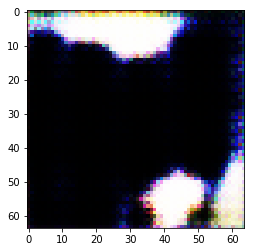

[2/400][0/692] Loss_D: 0.3091 Loss_G: 0.9263 D(x): 0.6469 D(G(z)): 0.2668 / 0.1042



[3/400][0/692] Loss_D: 0.4493 Loss_G: 0.6020 D(x): 0.3767 D(G(z)): 0.2842 / 0.1939



[4/400][0/692] Loss_D: 0.3451 Loss_G: 0.7421 D(x): 0.5143 D(G(z)): 0.2282 / 0.1591



[5/400][0/692] Loss_D: 0.3480 Loss_G: 0.6835 D(x): 0.5764 D(G(z)): 0.3444 / 0.2593



[6/400][0/692] Loss_D: 0.5419 Loss_G: 0.8272 D(x): 0.5722 D(G(z)): 0.5252 / 0.1298



[7/400][0/692] Loss_D: 0.3486 Loss_G: 0.8174 D(x): 0.5639 D(G(z)): 0.3095 / 0.1320



[8/400][0/692] Loss_D: 0.3314 Loss_G: 0.7177 D(x): 0.5050 D(G(z)): 0.2536 / 0.1726



[9/400][0/692] Loss_D: 0.3165 Loss_G: 0.7397 D(x): 0.6340 D(G(z)): 0.3188 / 0.2445



[10/400][0/692] Loss_D: 0.3253 Loss_G: 0.7597 D(x): 0.4703 D(G(z)): 0.2132 / 0.1129


In [19]:
### training here

step = 0
for epoch in range(epochs):
    for ii, (real_images) in tqdm(enumerate(train_loader), total=len(train_loader)):
        end = time()
        if (end -start) > 25000 :
            break
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        
        #----Combined Loss Function------------
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device) +  np.random.uniform(-0.1, 0.1)
        labels_LSGAN = torch.full((batch_size, 1), real_label, device=device) +  np.random.uniform(-0.1, 0.1)

        output_real = netD(real_images)
        errD_real_LSGAN = torch.mean((output_real - labels_LSGAN) ** 2)
        errD_real_LSGAN.backward(retain_graph=True)
        D_x = output_real.mean().item()
        
        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels_LSGAN.fill_(fake_label) + np.random.uniform(0, 0.2)
        output_fake = netD(fake.detach())
        errD_fake_LSGAN = torch.mean((output_fake - labels_LSGAN) ** 2)
        errD_fake_LSGAN.backward(retain_graph=True)
        D_G_z1 = output_fake.mean().item()
        errD_LSGAN = errD_real_LSGAN + errD_fake_LSGAN # LSGAN
        errD_RSGAN = BCE_stable(output_real - output_fake, labels) # RSGAN
        errD_RSGAN.backward(retain_graph=True)
        errD_RaLSGAN = (torch.mean((output_real - torch.mean(output_fake) - labels) ** 2) +  # RaLSGAN
                        torch.mean((output_fake - torch.mean(output_real) + labels) ** 2)) / 2
        errD_RaLSGAN.backward(retain_graph=True)
        errD = (errD_LSGAN + errD_RSGAN + errD_RaLSGAN) / 3.0
        #errD.backward(retain_graph=True)
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        
        #----- Combined Loss Function ---
        netG.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        output_fake = netD(fake)
        
        errG_LSGAN = torch.mean((output_fake - labels) ** 2)
        errG_LSGAN.backward(retain_graph=True)
        errG_RSGAN  =BCE_stable(output_fake - output_real, labels)
        errG_RSGAN.backward(retain_graph=True)
        errG_RaLSGAN = (torch.mean((output_real - torch.mean(output_fake) + labels) ** 2) +
                        torch.mean((output_fake - torch.mean(output_real) - labels) ** 2)) / 2
        errG_RaLSGAN.backward(retain_graph=True)
        errG = (errG_LSGAN + errG_RSGAN + errG_RaLSGAN) / 3.0
        D_G_z2 = output_fake.mean().item()
        optimizerG.step()
        
        if step % 692 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
            valid_image = netG(fixed_noise)
        step += 1
        lr_schedulerG.step(epoch)
        lr_schedulerD.step(epoch)

    if epoch % 50 == 0:
        show_generated_img()
    
torch.save(netG.state_dict(), 'generator.pth')
torch.save(netD.state_dict(), 'discriminator.pth')


## Generating Output Images

In [20]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 100
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    z = truncated_normal((im_batch_size, nz, n_one, n_one), threshold=1)
    gen_z = torch.from_numpy(z).float().to(device)    
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image((gen_images[i_image, :, :, :] +1.0)/2.0, os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))

import shutil
shutil.make_archive('images', 'zip', '../output_images')

'/kaggle/working/images.zip'

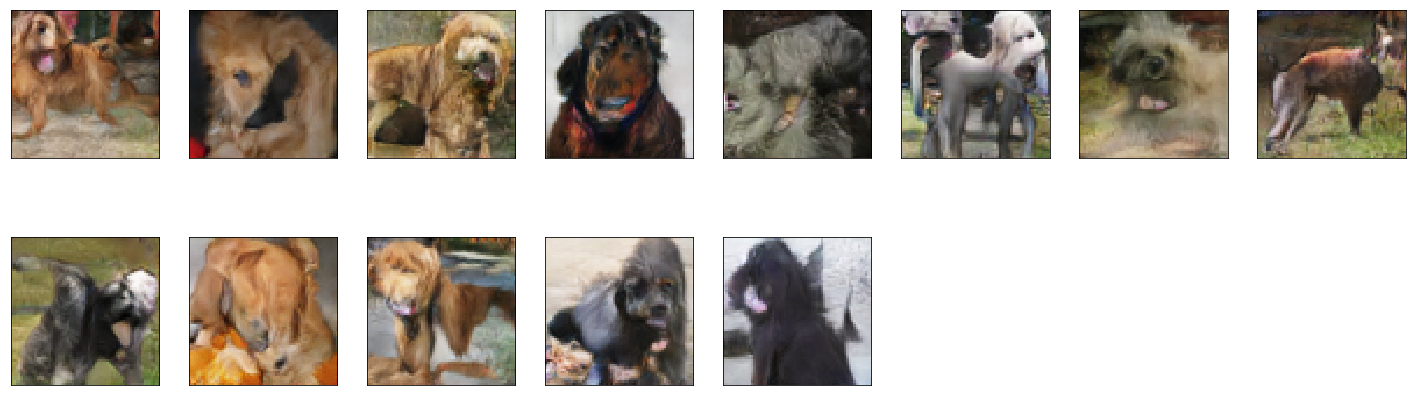

In [21]:
show_generated_img_all()

## Evaluation Metrics

In [22]:
from __future__ import absolute_import, division, print_function
import numpy as np
import os
import gzip, pickle
import tensorflow as tf
from scipy import linalg
import pathlib
import urllib
import warnings
from tqdm import tqdm
from PIL import Image

class KernelEvalException(Exception):
    pass

model_params = {
    'Inception': {
        'name': 'Inception', 
        'imsize': 64,
        'output_layer': 'Pretrained_Net/pool_3:0', 
        'input_layer': 'Pretrained_Net/ExpandDims:0',
        'output_shape': 2048,
        'cosine_distance_eps': 0.1
        }
}

def create_model_graph(pth):
    """Creates a graph from saved GraphDef file."""
    # Creates graph from saved graph_def.pb.
    with tf.gfile.FastGFile( pth, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString( f.read())
        _ = tf.import_graph_def( graph_def, name='Pretrained_Net')

def _get_model_layer(sess, model_name):
    # layername = 'Pretrained_Net/final_layer/Mean:0'
    layername = model_params[model_name]['output_layer']
    layer = sess.graph.get_tensor_by_name(layername)
    ops = layer.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            if shape._dims != []:
              shape = [s.value for s in shape]
              new_shape = []
              for j, s in enumerate(shape):
                if s == 1 and j == 0:
                  new_shape.append(None)
                else:
                  new_shape.append(s)
              o.__dict__['_shape_val'] = tf.TensorShape(new_shape)
    return layer

def get_activations(images, sess, model_name, batch_size=50, verbose=False):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 256.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the disposable hardware.
    -- verbose    : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- A numpy array of dimension (num images, 2048) that contains the
       activations of the given tensor when feeding inception with the query tensor.
    """
    inception_layer = _get_model_layer(sess, model_name)
    n_images = images.shape[0]
    if batch_size > n_images:
        print("warning: batch size is bigger than the data size. setting batch size to data size")
        batch_size = n_images
    n_batches = n_images//batch_size + 1
    pred_arr = np.empty((n_images,model_params[model_name]['output_shape']))
    for i in tqdm(range(n_batches)):
        if verbose:
            print("\rPropagating batch %d/%d" % (i+1, n_batches), end="", flush=True)
        start = i*batch_size
        if start+batch_size < n_images:
            end = start+batch_size
        else:
            end = n_images
                    
        batch = images[start:end]
        pred = sess.run(inception_layer, {model_params[model_name]['input_layer']: batch})
        pred_arr[start:end] = pred.reshape(-1,model_params[model_name]['output_shape'])
    if verbose:
        print(" done")
    return pred_arr


# def calculate_memorization_distance(features1, features2):
#     neigh = NearestNeighbors(n_neighbors=1, algorithm='kd_tree', metric='euclidean')
#     neigh.fit(features2) 
#     d, _ = neigh.kneighbors(features1, return_distance=True)
#     print('d.shape=',d.shape)
#     return np.mean(d)

def normalize_rows(x: np.ndarray):
    """
    function that normalizes each row of the matrix x to have unit length.

    Args:
     ``x``: A numpy matrix of shape (n, m)

    Returns:
     ``x``: The normalized (by row) numpy matrix.
    """
    return np.nan_to_num(x/np.linalg.norm(x, ord=2, axis=1, keepdims=True))


def cosine_distance(features1, features2):
    # print('rows of zeros in features1 = ',sum(np.sum(features1, axis=1) == 0))
    # print('rows of zeros in features2 = ',sum(np.sum(features2, axis=1) == 0))
    features1_nozero = features1[np.sum(features1, axis=1) != 0]
    features2_nozero = features2[np.sum(features2, axis=1) != 0]
    norm_f1 = normalize_rows(features1_nozero)
    norm_f2 = normalize_rows(features2_nozero)

    d = 1.0-np.abs(np.matmul(norm_f1, norm_f2.T))
    print('d.shape=',d.shape)
    print('np.min(d, axis=1).shape=',np.min(d, axis=1).shape)
    mean_min_d = np.mean(np.min(d, axis=1))
    print('distance=',mean_min_d)
    return mean_min_d


def distance_thresholding(d, eps):
    if d < eps:
        return d
    else:
        return 1

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
            
    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1 : Numpy array containing the activations of the pool_3 layer of the
             inception net ( like returned by the function 'get_predictions')
             for generated samples.
    -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
               on an representive data set.
    -- sigma1: The covariance matrix over activations of the pool_3 layer for
               generated samples.
    -- sigma2: The covariance matrix over activations of the pool_3 layer,
               precalcualted on an representive data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        # covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    # covmean = tf.linalg.sqrtm(tf.linalg.matmul(sigma1,sigma2))

    print('covmean.shape=',covmean.shape)
    # tr_covmean = tf.linalg.trace(covmean)

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    # return diff.dot(diff) + tf.linalg.trace(sigma1) + tf.linalg.trace(sigma2) - 2 * tr_covmean
#-------------------------------------------------------------------------------


def calculate_activation_statistics(images, sess, model_name, batch_size=50, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 255.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the available hardware.
    -- verbose     : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the incption model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the incption model.
    """
    act = get_activations(images, sess, model_name, batch_size, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma, act
    
def _handle_path_memorization(path, sess, model_name, is_checksize, is_check_png):
    path = pathlib.Path(path)
    files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
    imsize = model_params[model_name]['imsize']

    # In production we don't resize input images. This is just for demo purpose. 
    x = np.array([np.array(img_read_checks(fn, imsize, is_checksize, imsize, is_check_png)) for fn in files])
    m, s, features = calculate_activation_statistics(x, sess, model_name)
    del x #clean up memory
    return m, s, features

# check for image size
def img_read_checks(filename, resize_to, is_checksize=False, check_imsize = 64, is_check_png = False):
    im = Image.open(str(filename))
    if is_checksize and im.size != (check_imsize,check_imsize):
        raise KernelEvalException('The images are not of size '+str(check_imsize))
    
    if is_check_png and im.format != 'PNG':
        raise KernelEvalException('Only PNG images should be submitted.')

    if resize_to is None:
        return im
    else:
        return im.resize((resize_to,resize_to),Image.ANTIALIAS)

def calculate_kid_given_paths(paths, model_name, model_path, feature_path=None, mm=[], ss=[], ff=[]):
    ''' Calculates the KID of two paths. '''
    tf.reset_default_graph()
    create_model_graph(str(model_path))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        m1, s1, features1 = _handle_path_memorization(paths[0], sess, model_name, is_checksize = True, is_check_png = True)
        if len(mm) != 0:
            m2 = mm
            s2 = ss
            features2 = ff
        elif feature_path is None:
            m2, s2, features2 = _handle_path_memorization(paths[1], sess, model_name, is_checksize = False, is_check_png = False)
        else:
            with np.load(feature_path) as f:
                m2, s2, features2 = f['m'], f['s'], f['features']

        print('m1,m2 shape=',(m1.shape,m2.shape),'s1,s2=',(s1.shape,s2.shape))
        print('starting calculating FID')
        fid_value = calculate_frechet_distance(m1, s1, m2, s2)
        print('done with FID, starting distance calculation')
        distance = cosine_distance(features1, features2)        
        return fid_value, distance, m2, s2, features2


/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [23]:
if ComputeLB:
  
    # UNCOMPRESS OUR IMGAES 
    #with zipfile.ZipFile("../output_images/images.zip","r") as z:
    with zipfile.ZipFile("/kaggle/working/images.zip","r") as z:
        z.extractall("../tmp/images2/")

    # COMPUTE LB SCORE
    m2 = []; s2 =[]; f2 = []
    user_images_unzipped_path = '../tmp/images2/'
    images_path = [user_images_unzipped_path,'../input/generative-dog-images/all-dogs/all-dogs/']
    public_path = '../input/dog-face-generation-competition-kid-metric-input/classify_image_graph_def.pb'

    fid_epsilon = 10e-15

    fid_value_public, distance_public, m2, s2, f2 = calculate_kid_given_paths(images_path, 'Inception', public_path, mm=m2, ss=s2, ff=f2)
    distance_public = distance_thresholding(distance_public, model_params['Inception']['cosine_distance_eps'])
    print("FID_public: ", fid_value_public, "distance_public: ", distance_public, "multiplied_public: ",
            fid_value_public /(distance_public + fid_epsilon))
    
    # REMOVE FILES TO PREVENT KERNEL ERROR OF TOO MANY FILES
    ! rm -r ../tmp

100%|██████████| 412/412 [01:09<00:00,  4.31it/s]


m1,m2 shape= ((2048,), (2048,)) s1,s2= ((2048, 2048), (2048, 2048))
starting calculating FID
covmean.shape= (2048, 2048)
done with FID, starting distance calculation
d.shape= (10000, 20579)
np.min(d, axis=1).shape= (10000,)
distance= 0.21680300397091354
FID_public:  59.232984854724975 distance_public:  1 multiplied_public:  59.232984854724386
